In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split,cross_val_score,cross_val_predict
from sklearn.linear_model import LinearRegression,Lasso,ElasticNet,Ridge
from sklearn.metrics import mean_squared_error,r2_score

import statsmodels.api as smf
from scipy.stats import norm
from sklearn.preprocessing import scale
from sklearn import model_selection
import math

from warnings import filterwarnings
filterwarnings('ignore')
sns.set()

In [2]:
data = pd.read_csv("insurance.csv") 
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
data.describe().T 

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [5]:
data.isnull().sum() #No missing values

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Categorical Variable Analysis

male      676
female    662
Name: sex, dtype: int64


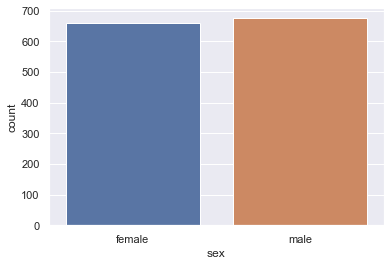

no     1064
yes     274
Name: smoker, dtype: int64


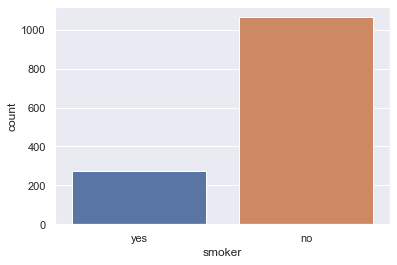

southeast    364
northwest    325
southwest    325
northeast    324
Name: region, dtype: int64


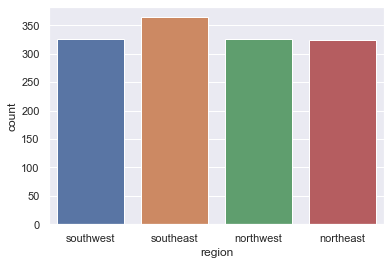

In [6]:
object_variables = data.select_dtypes(include=["object"])
for i in object_variables:
    print(object_variables[i].value_counts())
    sns.countplot(x=object_variables[i])
    plt.show()

## Discrete Variable Analysis

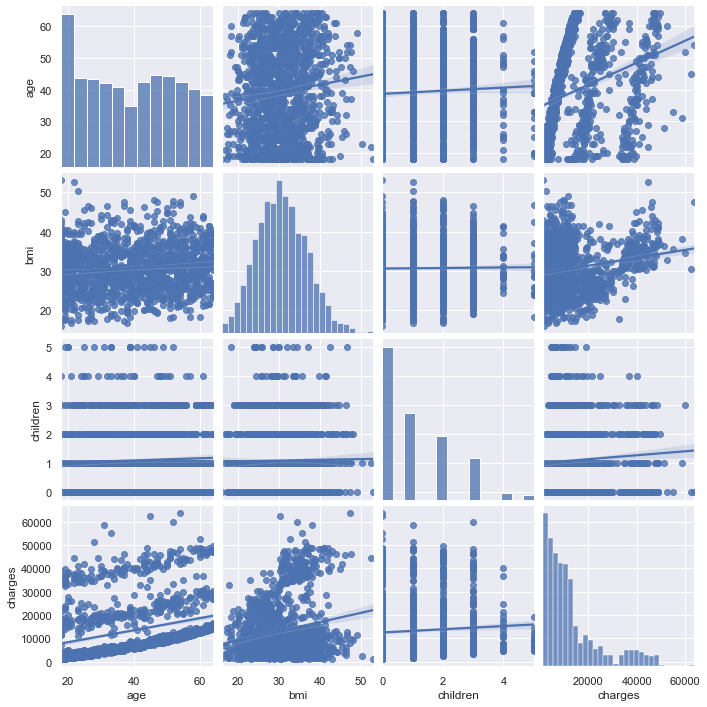

In [7]:
numeric_cols = ["age","bmi","children","charges"]
sns.pairplot(data[numeric_cols], height = 2.5, kind="reg")
plt.show()

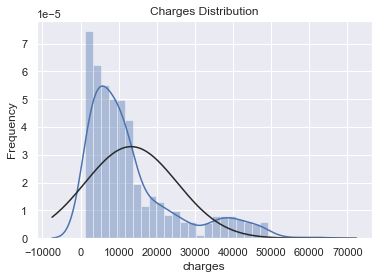

In [8]:
sns.distplot(data['charges'] , fit=norm);
plt.ylabel('Frequency')
plt.title('Charges Distribution')
plt.show();

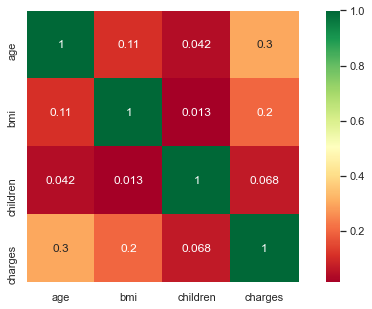

In [9]:
corr_mat = data[numeric_cols].corr()
plt.subplots(figsize=(10,5))
sns.heatmap(corr_mat, annot=True, square=True,cmap='RdYlGn');

## Encoding (One-Hot Encoding)

In [10]:
dummy_df_smoker = pd.get_dummies(data["smoker"],drop_first=True,dtype=np.int64,prefix="smoker_is")
dummy_df_sex = pd.get_dummies(data["sex"],drop_first=True,dtype=np.int64,prefix="sex_is")
dummy_df_region = pd.get_dummies(data["region"],dtype=np.int64,prefix="region_is")

data = pd.concat([data,dummy_df_smoker,dummy_df_sex,dummy_df_region],axis=1)
data = data.loc[:,~data.columns.duplicated()]
data = data.drop(['smoker', 'sex','region'],axis=1)

data.head()

,age,bmi,children,charges,smoker_is_yes,sex_is_male,region_is_northeast,region_is_northwest,region_is_southeast,region_is_southwest
0,19,27.900,0,16884.92400,1,0,0,0,0,1
1,18,33.770,1,1725.55230,0,1,0,0,1,0
2,28,33.000,3,4449.46200,0,1,0,0,1,0
3,33,22.705,0,21984.47061,0,1,0,1,0,0
4,32,28.880,0,3866.85520,0,1,0,1,0,0


## Train-Test Split

In [11]:
y= data["charges"]
X= data.drop(["charges"],axis=1)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.25) #0.75 train, 0.25 test size

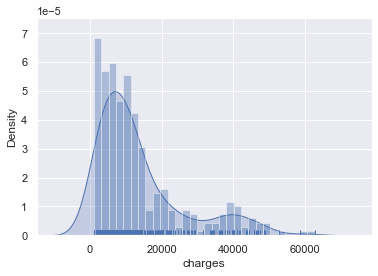

In [12]:
sns.distplot(y_test,hist=True,bins=30,rug=True,kde_kws={'shade':True}); #y_test distribution

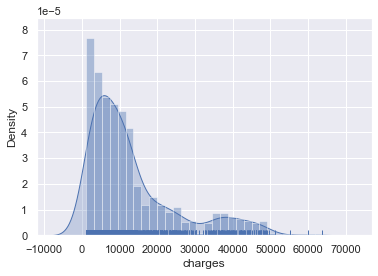

In [13]:
sns.distplot(y_train,hist=True,bins=30,rug=True,kde_kws={'shade':True}); #y_train distribution

In [14]:
X_train.head()

,age,bmi,children,smoker_is_yes,sex_is_male,region_is_northeast,region_is_northwest,region_is_southeast,region_is_southwest
1244,18,33.330,0,0,1,0,0,1,0
496,31,23.600,2,0,0,0,0,0,1
253,27,30.300,3,0,1,0,0,0,1
564,18,32.120,2,0,0,0,0,1,0
1190,31,32.775,2,0,0,0,1,0,0


In [15]:
y_train[0:5]

1244    1135.94070
496     4931.64700
253     4260.74400
564     2801.25880
1190    5327.40025
Name: charges, dtype: float64

In [16]:
X_test.head()

,age,bmi,children,smoker_is_yes,sex_is_male,region_is_northeast,region_is_northwest,region_is_southeast,region_is_southwest
492,18,25.08,0,0,0,1,0,0,0
939,53,29.48,0,0,1,0,0,1,0
1119,30,19.95,3,0,0,0,1,0,0
1308,25,30.20,0,1,0,0,0,0,1
931,39,32.50,1,0,0,0,0,0,1


In [17]:
y_test[0:5]

492      2196.4732
939      9487.6442
1119     5693.4305
1308    33900.6530
931      6238.2980
Name: charges, dtype: float64

## 1-Lasso Regression Model

In [25]:
lasso_model = Lasso().fit(X_train,y_train)
y_pred2 = lasso_model.predict(X_test)
r2_test = r2_score(y_test,y_pred2)
rmse_test = np.sqrt(mean_squared_error(y_test,y_pred2))
rmse_train = np.sqrt(mean_squared_error(y_train , lasso_model.predict(X_train)))
r2_train = r2_score(y_train , lasso_model.predict(X_train))

In [26]:
print("R2 Score for Test Set of Lasso Regression Model: ",r2_test)
print("R2 Score for Train Set of Lasso Regression Model: ",r2_train)
print("RMSE for Test Set of Lasso Regression Model: ",rmse_test)
print("RMSE for Train Set of Lasso Regression Model: ",rmse_train)

R2 Score for Test Set of Lasso Regression Model:  0.7452232198574146
R2 Score for Train Set of Lasso Regression Model:  0.7520757406310888
RMSE for Test Set of Lasso Regression Model:  6279.748798858919
RMSE for Train Set of Lasso Regression Model:  5969.209240761039


## 2-Linear Regression Model

In [27]:
linear_model = LinearRegression().fit(X_train,y_train)
y_pred2 = linear_model.predict(X_test)
r2_test = r2_score(y_test,y_pred2)
rmse_test = np.sqrt(mean_squared_error(y_test,y_pred2))
rmse_train = np.sqrt(mean_squared_error(y_train , linear_model.predict(X_train)))
r2_train = r2_score(y_train , linear_model.predict(X_train))

In [28]:
print("R2 Score for Test Set of Linear Regression Model: ",r2_test)
print("R2 Score for Train Set of Linear Regression Model: ",r2_train)
print("RMSE for Test Set of Linear Regression Model: ",rmse_test)
print("RMSE for Train Set of Linear Regression Model: ",rmse_train)

R2 Score for Test Set of Linear Regression Model:  0.7452565933090349
R2 Score for Train Set of Linear Regression Model:  0.7520759470356626
RMSE for Test Set of Linear Regression Model:  6279.337490269047
RMSE for Train Set of Linear Regression Model:  5969.206755985348


## 3-Ridge Regression Model

In [29]:
ridge_model = Ridge().fit(X_train,y_train)
y_pred = ridge_model.predict(X_test)
r2_test = r2_score(y_test,y_pred)
rmse_test = np.sqrt(mean_squared_error(y_test,y_pred))
rmse_train = np.sqrt(mean_squared_error(y_train , ridge_model.predict(X_train)))
r2_train = r2_score(y_train , ridge_model.predict(X_train))

In [30]:
print("R2 Score for Test Set of Ridge Regression Model: ",r2_test)
print("R2 Score for Train Set of Ridge Regression Model: ",r2_train)
print("RMSE for Test Set of Ridge Regression Model: ",rmse_test)
print("RMSE for Train Set of Ridge Regression Model: ",rmse_train)

R2 Score for Test Set of Ridge Regression Model:  0.7447467312442557
R2 Score for Train Set of Ridge Regression Model:  0.7520526543461794
RMSE for Test Set of Ridge Regression Model:  6285.618311515677
RMSE for Train Set of Ridge Regression Model:  5969.487155592025


In [31]:
x_ols =X.iloc[:,[0,1,2,3,5,6,7,8]].values
reg_model_ols = smf.OLS(endog=y , exog =x_ols).fit()
print(reg_model_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                charges   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.750
Method:                 Least Squares   F-statistic:                     572.7
Date:                Fri, 28 May 2021   Prob (F-statistic):               0.00
Time:                        12:19:47   Log-Likelihood:                -13548.
No. Observations:                1338   AIC:                         2.711e+04
Df Residuals:                    1330   BIC:                         2.715e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           256.9736     11.891     21.610      0.0